# Emotone - Melody generation based on emotion
## HCAI project

### Author:
- Joana Simoes, No. 2019217013

### Objective
This project aims to create an artificial intelligence system capable of generating melodies that induce certain emotions in people.

### References

The project was heavily based on the work of Lucas N. Ferreira and Jim Whitehead, their work can be accessed at https://arxiv.org/abs/2103.06125.

### Notes:
- The files that come with the project contain the project code, this notebook only serves to "put the pieces together in one place",  and it is advised to only run the project from this notebook.

- The sections should be run sequentially, in case you want to run the whole program (train the system from scratch). Note that this option may take more than 15 hours, depending on the machines. 

- To save time, checkpoints have been created throughout the notebook, so that each part can be run separately. 

- The sections 'Imports', 'Variables', should always be run first. 

- To train the classifier, change the weights of the LSTM (Evolve LSTM) or generate tunes, the "Variable post-training LSTM" must be run before them.

In [ ]:
! pip install tensorflow==2.9.1

In [ ]:
! pip install music21

## Imports

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/emotone')

In [ ]:
import midi_encoder
import train_generative
import train_classifier
import evolve_generative
import midi_generator
import plot_results

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Variables

#### for train

In [ ]:
PROJECT_PATH = os.path.join('drive', 'MyDrive', 'emotone')

In [ ]:
DATA_PATH = os.path.join(PROJECT_PATH, 'vgmidi')

In [ ]:
SAVE_CHECKPOINTS = os.path.join(PROJECT_PATH, 'trained')

In [ ]:
GENERATED_PATH = os.path.join(PROJECT_PATH, 'generated')

In [ ]:
units = 4096
layers = 1
epochs = 5
batch = 32
embed = 64
learning_rate = 0.001
sequence_len = 256
drop = 0.05
cellix = -3

In [ ]:
unlabelled_train_path = os.path.join(DATA_PATH, 'unlabelled', 'train')
unlabelled_test_path = os.path.join(DATA_PATH, 'unlabelled', 'test')

In [ ]:
override_path = ''

#### for evolve 

In [ ]:
elitism = 0.2
mutation = 0.2
population_size = 20

## Train generative LSTM

In [ ]:
train_text, train_vocab = midi_encoder.load(unlabelled_train_path)
test_text, test_vocab = midi_encoder.load(unlabelled_test_path)

In [ ]:
# build vocabulary
vocab_dict, vocab_size = train_generative.build_vocabulary(train_vocab, test_vocab, SAVE_CHECKPOINTS)

In [ ]:
# build dataset from encoded midis
train_dataset = train_generative.build_dataset(train_text, vocab_dict, sequence_len, batch)
test_dataset = train_generative.build_dataset(test_text, vocab_dict, sequence_len, batch)

In [ ]:
# build generative model
generative_model = train_generative.build_generative_model(vocab_size, embed, units, layers, batch, drop)

In [ ]:
history = train_generative.train_generative_model(generative_model, train_dataset, test_dataset, epochs, learning_rate, SAVE_CHECKPOINTS)

Epoch 1/5
2332/2332 [==============================] - 2916s 1s/step - loss: 3.2631 - val_loss: 3.0546
Epoch 2/5
2332/2332 [==============================] - 2899s 1s/step - loss: 2.8322 - val_loss: 2.8492
Epoch 3/5
2332/2332 [==============================] - 2911s 1s/step - loss: 2.7174 - val_loss: 2.7404
Epoch 4/5
 976/2332 [===========>..................] - ETA: 27:01 - loss: 2.6538

In [ ]:
print(history)

In [ ]:
# Persist sentiment classifier
with open(os.path.join(SAVE_CHECKPOINTS, 'generative_model.p'), "wb") as f:
    pickle.dump(generative_model, f)

## Variables pos-training LSTM

In [ ]:
vocabulary_path = os.path.join(SAVE_CHECKPOINTS, 'vocabulary_dict.json')
clf_checkpoint = os.path.join(SAVE_CHECKPOINTS, 'sentiment_classifier.p') 

In [ ]:
midis_path = os.path.join(DATA_PATH, 'labelled', 'midi')
data_path= os.path.join(DATA_PATH, 'labelled', 'dataset', 'sentiment_labelled.csv')
test_percentage = 0.2

In [ ]:
# load vocabulary
with open(vocabulary_path) as input_file:
  vocabulary = json.load(input_file)

# vocabulary size
vocabulary_size = len(vocabulary)

# create indexes vocabulary
indexes_vocabulary = {index: char for char, index in vocabulary.items()}

## Generate midi

In [ ]:
sequence_init = '.'

In [ ]:
filename = 'test_generated_classif.mid'

In [ ]:
override = {}
try:
    with open(override_path, 'r') as over_file:
        override = json.load(over_file)
except FileNotFoundError:
    print('Override file does not exist')

Override file does not exist


In [ ]:
# rebuild generative model from checkpoint
generative_model = train_generative.build_generative_model(vocabulary_size, embed, units, layers, 1, drop)
generative_model.load_weights(tf.train.latest_checkpoint(SAVE_CHECKPOINTS))
generative_model.build(tf.TensorShape([1, None]))

In [ ]:
generative_model.get_layer(index=cellix)

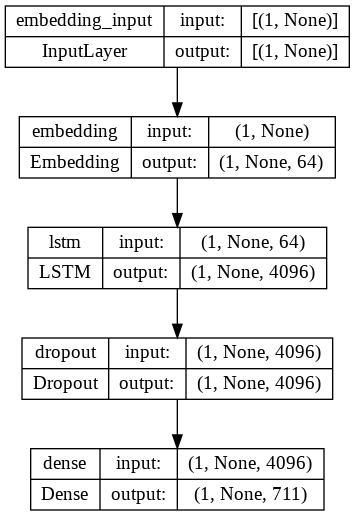

In [ ]:
tf.keras.utils.plot_model(
    generative_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

In [ ]:
# generate midi as text
midi_text = midi_generator.generate_midi(generative_model, vocabulary, indexes_vocabulary, sequence_init, sequence_len, layer_idx=cellix, override=override)

Can't process char .


In [ ]:
# write midi
midi_encoder.write(midi_text, os.path.join(GENERATED_PATH, filename))

## Train classifier

In [ ]:
# rebuild generative model from checkpoint
generative_model = train_generative.build_generative_model(vocabulary_size, embed, units, layers, 1, drop)
generative_model.load_weights(tf.train.latest_checkpoint(SAVE_CHECKPOINTS))
generative_model.build(tf.TensorShape([1, None]))

In [ ]:
#build datasets
X, y = train_classifier.build_dataset(midis_path, data_path, generative_model, vocabulary, cellix)

X.tofile(os.path.join(DATA_PATH, 'classifier_X.csv'), sep = ',')
y.tofile(os.path.join(DATA_PATH, 'classifier_y.csv'), sep = ',')

In [ ]:
data_X = np.genfromtxt(os.path.join(DATA_PATH, 'classifier_X.csv'))
data_y = np.genfromtxt(os.path.join(DATA_PATH, 'classifier_y.csv'))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=42, shuffle=True)

train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# train classifier
sentiment_neurons, score = train_classifier.train_classifier_model(train_dataset, test_dataset, clf_checkpoint)

In [ ]:
print(f'Total neurons used: {len(sentiment_neurons)}')
print('Sentiment neurons:')
print(sentiment_neurons)
print(f'Model Accuracy: {score}')

## Evolve LSTM

In [ ]:
# save dictionary
sentiment_class = {1: 'joy', 2: 'sad', 3: 'relaxed', 4: 'distress'}
# load generative model
generative_model = train_generative.build_generative_model(vocabulary_size, embed, units, layers, batch_size=1)
generative_model.load_weights(tf.train.latest_checkpoint(SAVE_CHECKPOINTS))
generative_model.build(tf.TensorShape([1, None]))
# load classifier model
with open(clf_checkpoint, 'rb') as file:
    classifier_model = pickle.load(file)

In [ ]:
for sentiment in range(1, 4+1):

  print('SENTIMENT: ', [sentiment_class[sentiment]])

  sentiment_neuron_indexes = train_classifier.get_activated_neurons(classifier_model)
  genome_size = len(sentiment_neuron_indexes)

  # evolve(population_size, genome_size, generative_model, classifier_model, vocabulary, indexes_vocabulary,
  #            layer_index, sentiment, mutation_prob, elitism_prob, epochs):
  population, fitness = evolve_generative.evolve(population_size, genome_size, generative_model, classifier_model, vocabulary,
                                indexes_vocabulary, cellix, sentiment, mutation, elitism, epochs)

  # best individual
  best_index = np.argmax(fitness)
  best_individual = population[best_index]

  # use the best individual to create a dictionary
  neurons = {}
  for i, index in enumerate(sentiment_neuron_indexes):
      neurons[str(index)] = best_individual[i]
  print('Neurons: \n:', neurons)

  save_path = os.path.join(SAVE_CHECKPOINTS, f'neurons_{sentiment_class[sentiment]}.json')
  with open(save_path, 'w') as file:
      json.dump(neurons, file)

## Generate pieces (joy, distress, sad, relaxed)

In [ ]:
# save dictionary
sentiment_class = {1: 'joy' , 2: 'sad', 3: 'relaxed', 4: 'distress'}

In [ ]:
sequence_init = '.'

In [ ]:
number_musics = 5

In [ ]:
# rebuild generative model from checkpoint
generative_model = train_generative.build_generative_model(vocabulary_size, embed, units, layers, 1, drop)
generative_model.load_weights(tf.train.latest_checkpoint(SAVE_CHECKPOINTS))
generative_model.build(tf.TensorShape([1, None]))

In [ ]:
# load classifier model
with open(clf_checkpoint, 'rb') as file:
    classifier_model = pickle.load(file)

In [ ]:
confusion_matrix = pd.DataFrame(data=np.zeros((4, 4)),index=[1, 2, 3, 4], columns=[1, 2, 3, 4])

In [ ]:
musics = []
predictions = []
original_emotions = []

In [ ]:
count = 0
for emotion_index, emotion in reversed(sentiment_class.items()):
  override_path = os.path.join(SAVE_CHECKPOINTS, f'neurons_{emotion}.json')
  try:
    with open(override_path, 'r') as over_file:
        override = json.load(over_file)
  except FileNotFoundError:
      print('Override file does not exist')
  for i in range(1, number_musics+1):
    music_file = f'music_{count}.mid'
    count += 1
    # generate midi as text
    midi_text = midi_generator.generate_midi(generative_model, vocabulary, indexes_vocabulary, sequence_init, sequence_len, override=override)

    # write midi
    midi_encoder.write(midi_text, os.path.join(GENERATED_PATH,music_file))

    # classify music
    midi_ind = train_classifier.encode_sentence(generative_model, midi_text, vocabulary, cellix)
    pred = classifier_model.predict([midi_ind])
    confusion_matrix[pred[0]][emotion_index] = confusion_matrix[pred[0]][emotion_index] + 1
    musics.append(music_file)
    predictions.append(pred[0])
    original_emotions.append(emotion_index)

In [ ]:
confusion_matrix.to_csv(os.path.join(GENERATED_PATH, 'confusion_matrix.csv'), index=False)

In [ ]:
confusion_matrix

In [ ]:
music_classification = pd.DataFrame(columns=['music', 'given_emotion','prediction'])

In [ ]:
music_classification.music = musics
music_classification.given_emotion = original_emotions
music_classification.prediction = predictions

In [ ]:
music_classification

In [ ]:
music_classification.to_csv(os.path.join(GENERATED_PATH, 'music_classification.csv'), index=False)

## Generate melodies with emotion

In [ ]:
sequence_init = '.' # TODO: if you want, change the initial sequence (notes of the music)
sequence_len = 256 # TODO: if you want, change the number of prediction the system should made

In [ ]:
# save dictionary
sentiment_class = {1: 'joy' , 2: 'sad', 3: 'relaxed', 4: 'distress'}

In [ ]:
emotion = 2 # TODO: select emotion index (1, 2, 3 or 4) or None to use the default LSTM prediction

In [ ]:
music_name = 'generated_music' # TODO: select music name
filename = f'{music_name}.mid'

In [ ]:
override = {}
try:
    if emotion is not None:
      override_path = os.path.join(SAVE_CHECKPOINTS, f'neurons_{sentiment_class[emotion]}.json')
    else:
      override_path = ''
    with open(override_path, 'r') as over_file:
        override = json.load(over_file)
except FileNotFoundError:
    print('Override file does not exist')

Override file does not exist


In [ ]:
# rebuild generative model from checkpoint
generative_model = train_generative.build_generative_model(vocabulary_size, embed, units, layers, 1, drop)
generative_model.load_weights(tf.train.latest_checkpoint(SAVE_CHECKPOINTS))
generative_model.build(tf.TensorShape([1, None]))

In [ ]:
generative_model.get_layer(index=cellix)

In [ ]:
# generate midi as text
midi_text = midi_generator.generate_midi(generative_model, vocabulary, indexes_vocabulary, sequence_init, sequence_len, layer_idx=cellix, override=override)

Can't process char .


In [ ]:
# write midi
filepath = os.path.join(GENERATED_PATH, filename)
midi_encoder.write(midi_text, filepath)